In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from data_models.basic import LOCOData
from conformal_prediction.basic import SplitConformal
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict
import json
import aux_funcs
from scipy.stats import foldnorm, norm
from scipy.stats import t
from explainable_models.variable_importance.LOCO import SimpleLOCO, plot_ci
from matplotlib.transforms import Affine2D
from mpl_axes_aligner import align
from data_models.basic import LinearData, LinearDataCorrelated, LinearDataTest
from conformal_prediction.basic import SplitConformal, QuantileConformal
from sklearn.linear_model import LinearRegression, QuantileRegressor

# Own Variable Importance

In [3]:
weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

cov_matrix = np.eye(N=10)
split_percentages=[0.70, 0.20, 0.10]
mu = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
locodata = LinearDataCorrelated(n=1000, mu=mu, cov_matrix=cov_matrix, std=1, weights=weights)
# locodata = LOCOData(n=10000)
locodata.X_y_split(y='Y')

In [4]:
model = RandomForestRegressor()

In [13]:
loco = SimpleLOCO(model=model, train_data=locodata.data, y_feature='Y')

In [14]:
x = []
y = []
yerr = []
for var in locodata.train_data.columns.tolist()[:-1]:
    feature_importance, ci = loco.run_loco(variable=var, prop=0.7, loss_type='mean', alpha=0.05, bootstrap=200)
    x.append(var)
    y.append(feature_importance)
    yerr.append(ci)

In [15]:
random_forest = RandomForestRegressor()
random_forest.fit(locodata.train_data_X, locodata.train_data_y)

RandomForestRegressor()

In [19]:
random_forest.feature_importances_

array([0.18053561, 0.36827661, 0.17338977, 0.09458492, 0.09270135,
       0.09051174])

In [12]:
weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

cov_matrix = np.eye(N=10)
split_percentages=[0.45, 0.45, 0.10]
mu = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
locodata = LinearDataCorrelated(n=1000, mu=mu, cov_matrix=cov_matrix, std=1, weights=weights)
# locodata = LOCOData(n=10000)
locodata.X_y_split(y='Y')

plot = None
B = 10
model = LinearRegression()
conformal_type = SplitConformal
alpha = 0.05

boot_size = []
vars_j_1 = []
vars_j_2 = []
vars_LOCO = []
boot_size_1 = defaultdict(list)
boot_size_2 = defaultdict(list)
boot_LOCO = defaultdict(list)

model_full = model
model_full.fit(locodata.train_data_X, locodata.train_data_y)
model_full = copy.copy(model_full)

conformal_predictor = conformal_type(alpha=alpha)
lambda_all = conformal_predictor.calibrate(data_X=locodata.calib_data_X, data_y=locodata.calib_data_y, 
                                                        model=model_full, rand_state=None)
pred_all = conformal_predictor.predict(locodata.test_data_X, model=model_full, lambda_conformal=lambda_all)

cov, size = conformal_predictor.evaluate(pred_all, locodata.test_data_y)

data_X_train = copy.copy(locodata.train_data_X)
data_X_calib = copy.copy(locodata.calib_data_X)
data_X_test = copy.copy(locodata.test_data_X)
    
for variable in locodata.calib_data_X.columns:

    # Train Twice
    data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
    data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
    data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

    model_j_2 = model
    model_j_2.fit(data_X_train_j_2, locodata.train_data_y)

    conformal_predictor_j = SplitConformal(alpha=alpha)

    lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=locodata.calib_data_y, 
                                                    model=model_j_2, rand_state=None)
    pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

    cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, locodata.test_data_y)
    vars_j_2.append(size_j_2-size)

    # Train Once
    data_X_calib_j_1 = copy.copy(data_X_calib)
    data_X_calib_j_1[variable] = 0
    data_X_test_j_1 = copy.copy(data_X_test)
    data_X_test_j_1[variable] = 0   

    conformal_predictor_j = SplitConformal(alpha=alpha)

    lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=locodata.calib_data_y, 
                                                    model=model_full, rand_state=None)
    pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

    cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, locodata.test_data_y)
    vars_j_1.append(size_j_1-size)

    # LOCO
    vars_LOCO.append(np.median(abs(locodata.test_data_y-model_j_2.predict(data_X_test_j_2))-abs(locodata.test_data_y-model_full.predict(data_X_test))))


# x = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

# fig, ax1 = plt.subplots(figsize=(12,8))

# trans1 = Affine2D().translate(-0.2, 0.0) + ax1.transData
# trans2 = Affine2D().translate(+0.2, 0.0) + ax1.transData
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('CP6 Variable Importance')
# p1 = ax1.errorbar(x, vars_j_1, yerr=0, fmt='o', transform=trans1, color='red', label='CP-1')
# p2 = ax1.errorbar(x, vars_j_2, yerr=0, fmt='o', transform=trans2, color='black', label='CP-2')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_ylabel('LOCO Variable Importance') 
# p3 = ax2.errorbar(x, vars_LOCO, yerr=0, fmt='o', label='LOCO')
# plt.axline(xy1=(0, 0), slope=0, color='r', linestyle='--')
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.title('LOCO vs CP6')

# # Adjust the plotting range of two y axes
# org1 = 0.0  # Origin of first axis
# org2 = 0.0  # Origin of second axis
# pos = 0.1  # Position the two origins are aligned
# align.yaxes(ax1, org1, ax2, org2, pos)
# plt.show()

for i in range(B):

    if i % 10 == 0:
        print(i)

    train_rand = np.random.choice(np.arange(0, len(locodata.train_data)), size=len(locodata.train_data), replace=True)
    calib_rand = np.random.choice(np.arange(0, len(locodata.calib_data)),size=len(locodata.calib_data), replace=True)

    train_data_X = copy.copy(locodata.train_data_X.iloc[train_rand])
    train_data_y = copy.copy(locodata.train_data_y.iloc[train_rand])
    calib_data_X = copy.copy(locodata.calib_data_X.iloc[calib_rand])
    calib_data_y = copy.copy(locodata.calib_data_y.iloc[calib_rand])

    model_full = model
    model_full.fit(train_data_X, train_data_y)
    model_full = copy.copy(model_full)

    conformal_predictor = conformal_type(alpha=alpha)
    lambda_all = conformal_predictor.calibrate(data_X=calib_data_X, data_y=calib_data_y, 
                                                          model=model_full, rand_state=None)
    pred_all = conformal_predictor.predict(locodata.test_data_X, model=model_full, lambda_conformal=lambda_all)

    cov, size = conformal_predictor.evaluate(pred_all, locodata.test_data_y)

    boot_size.append(size)

    data_X_train = copy.copy(train_data_X)
    data_X_calib = copy.copy(calib_data_X)
    data_X_test = copy.copy(locodata.test_data_X)
    
    for variable in locodata.calib_data_X.columns:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j_2 = model
        model_j_2.fit(data_X_train_j_2, train_data_y)

        conformal_predictor_j = SplitConformal(alpha=alpha)

        lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=calib_data_y, 
                                                     model=model_j_2, rand_state=None)
        pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

        cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, locodata.test_data_y)

        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(data_X_calib)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(data_X_test)
        data_X_test_j_1[variable] = 0   

        conformal_predictor_j = SplitConformal(alpha=alpha)

        lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=calib_data_y, 
                                                     model=model_full, rand_state=None)
        pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

        cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, locodata.test_data_y)

        boot_size_1[variable].extend([size_j_1])

        # LOCO
        boot_LOCO[variable].extend([np.median(abs(locodata.test_data_y-model_j_2.predict(data_X_test_j_2))-abs(locodata.test_data_y-model_full.predict(data_X_test)))])

0


In [13]:
import scipy

yerr_1 = []
yerr_2 = []
yerr_LOCO = []

for i, variable in enumerate(locodata.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    std_1 = np.std(data_1, ddof=1)
    std_2 = np.std(data_2, ddof=1)
    std_LOCO = np.std(boot_LOCO[variable], ddof=1)
    h_1 = scipy.stats.norm.ppf(1-0.2/2)*std_1
    yerr_1.append(h_1)
    h_2 = scipy.stats.norm.ppf(1-0.2/2)*std_2
    yerr_2.append(h_2)
    h_LOCO = scipy.stats.norm.ppf(1-0.2/2)*std_LOCO
    yerr_LOCO.append(h_LOCO)

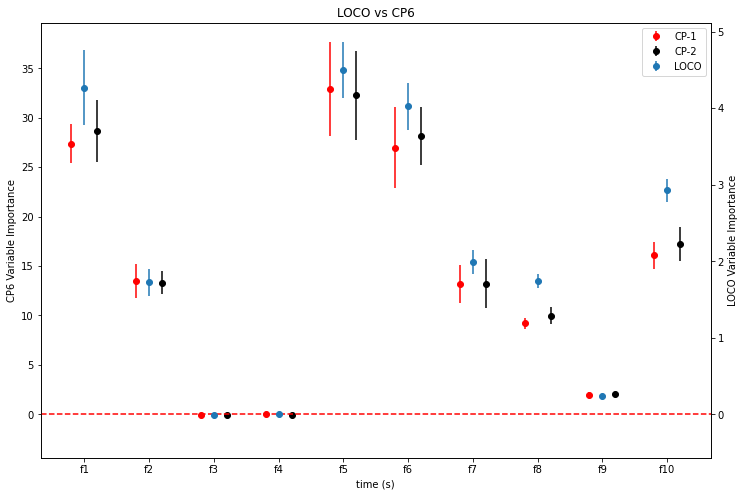

In [14]:
x = locodata.calib_data_X.columns

fig, ax1 = plt.subplots(figsize=(12,8))

trans1 = Affine2D().translate(-0.2, 0.0) + ax1.transData
trans2 = Affine2D().translate(+0.2, 0.0) + ax1.transData
ax1.set_xlabel('time (s)')
ax1.set_ylabel('CP6 Variable Importance')
# ax1.set_ylim((-0.1, 1.2))
p1 = ax1.errorbar(x, vars_j_1, yerr=yerr_1, fmt='o', transform=trans1, color='red', label='CP-1')
p2 = ax1.errorbar(x, vars_j_2, yerr=yerr_2, fmt='o', transform=trans2, color='black', label='CP-2')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('LOCO Variable Importance') 
p3 = ax2.errorbar(x, vars_LOCO, yerr=yerr_LOCO, fmt='o', label='LOCO')
plt.axline(xy1=(0, 0), slope=0, color='r', linestyle='--')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title('LOCO vs CP6')

# Adjust the plotting range of two y axes
org1 = 0.0  # Origin of first axis
org2 = 0.0  # Origin of second axis
pos = 0.1  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)

# plt.savefig('images/Linear_data/LOCO_vs_CP6_new_alpha_50')
plt.show()